In [1]:
import pandas as pd
# pd.set_option('display.max_rows', 5)

with open("pklDat.pkl", "rb") as file:
    data = pd.read_pickle(file)

final_df = data["final_df"]
trait_dict = data["trait_dict"]
exp = data["experimental_data"]
tiga = data["tiga_data"]

exp["diseaseName"] = exp["diseaseName"].transform(lambda x: x.lower())
tiga["trait"] = tiga["trait"].transform(lambda x: x.lower())

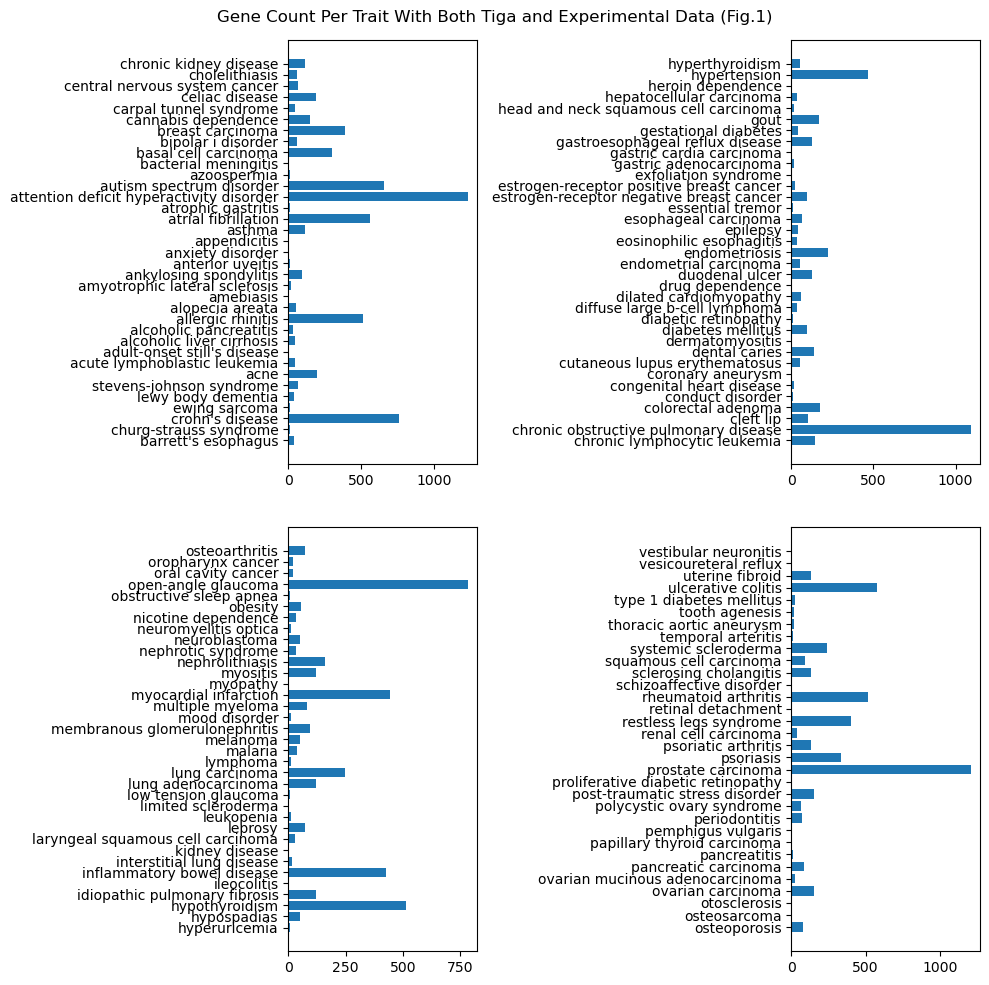

In [ ]:
import matplotlib.pyplot as plt
from more_itertools import chunked

count_dict = {x: len(trait_dict[x]) for x in trait_dict.keys()}
count_df = pd.DataFrame.from_dict(count_dict.items())

traits = list(count_dict.keys())
count = list(count_dict.values())

t_chunk = list(chunked(traits, (len(traits) // 4) + 1))
c_chunk = list(chunked(count, (len(count) // 4) + 1))


plt.figure(figsize=(10, 10))

plt.subplot(
    2,
    2,
    1,
)
plt.barh(t_chunk[0], c_chunk[0])

plt.subplot(2, 2, 2)
plt.barh(t_chunk[1], c_chunk[1])

plt.subplot(2, 2, 3)
plt.barh(t_chunk[2], c_chunk[2])

plt.subplot(2, 2, 4)
plt.barh(t_chunk[3], c_chunk[3])

plt.tight_layout(h_pad=3)
plt.suptitle("Gene Count Per Trait With Both Tiga and Experimental Data (Fig.1)")
plt.subplots_adjust(top=0.95)

# count_df.to_excel("Fig1_data.xlsx")

Text(0.5, 1.0, 'carpal tunnel syndrome (integrated)')

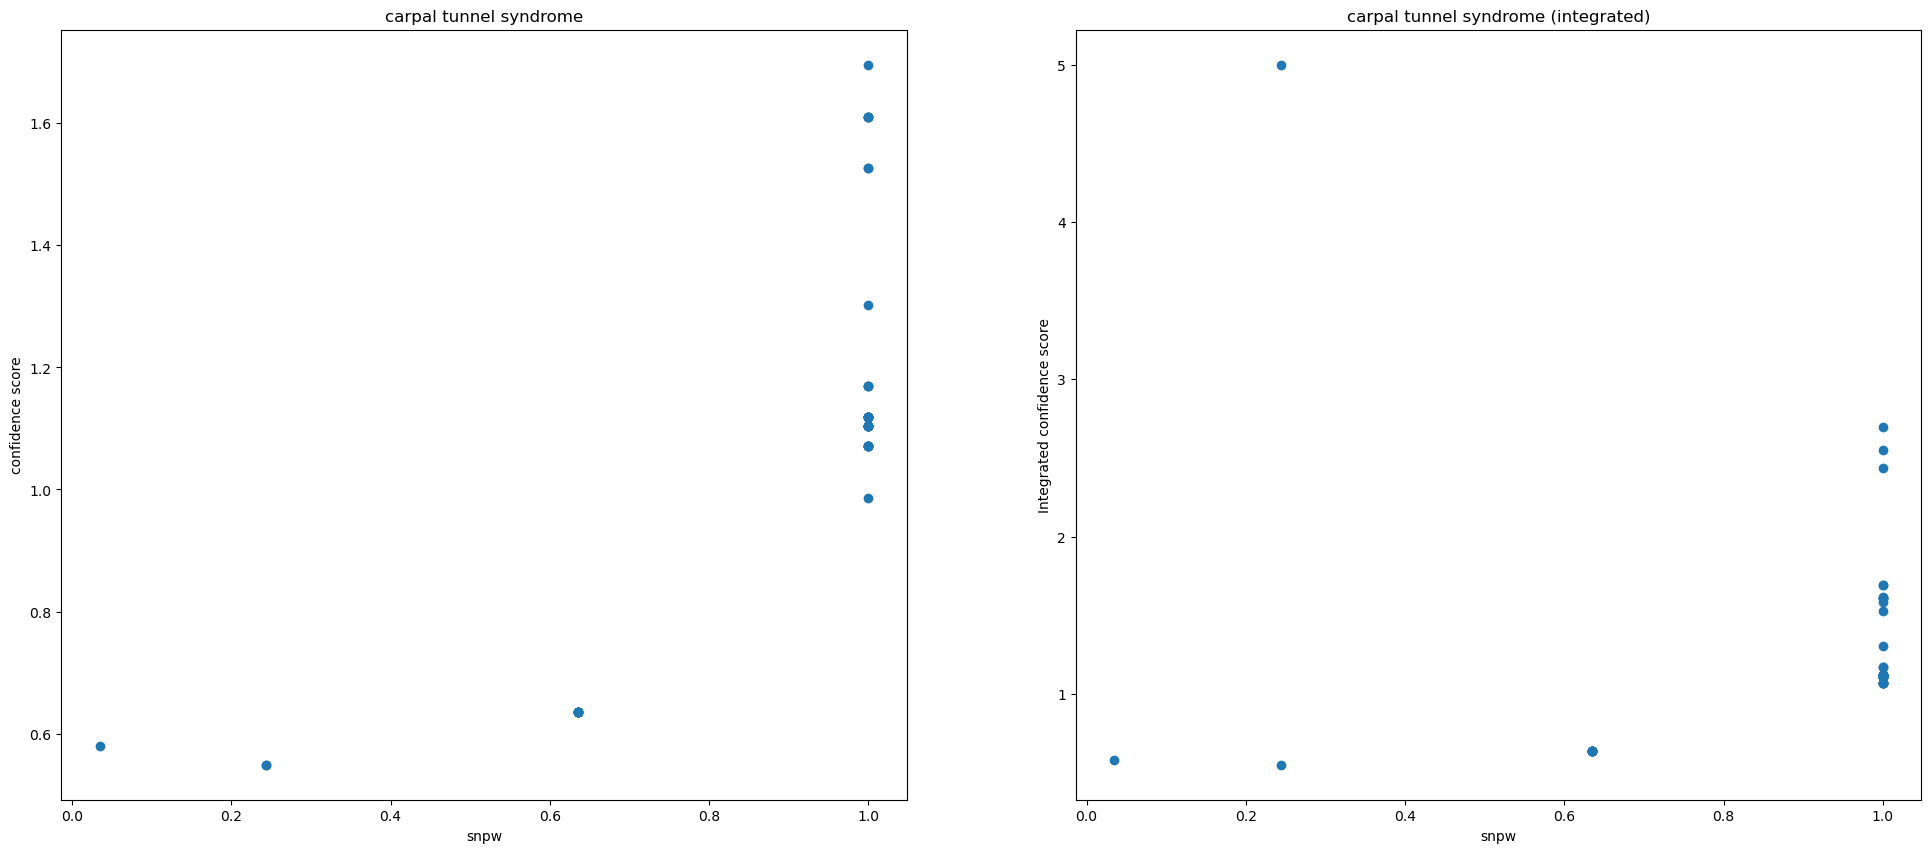

In [61]:
import random

diseases = list(trait_dict.keys())
selected = diseases[random.randint(0, len(diseases) - 1)]
data = trait_dict[selected]
snpw = data["n_snpw"]
int_conf_score = data["integrated_confidenceScore"]
exp_conf_score = data["confidenceScore"]


figs, axs = plt.subplots(1, 2, figsize=(24, 10), sharex=True)

plt.subplot(1, 2, 1)
plt.scatter(snpw, exp_conf_score)
plt.xlabel("snpw")
plt.ylabel("confidence score")
plt.title(selected)

plt.subplot(1, 2, 2)
plt.scatter(snpw, int_conf_score)
plt.xlabel("snpw")
plt.ylabel("Integrated confidence score")
plt.title(selected + " (integrated)")

<Axes: title={'center': 'Gene Counts For Traits With Mixed Tiga and Experimental Data (Fig.2)'}, ylabel='Key'>

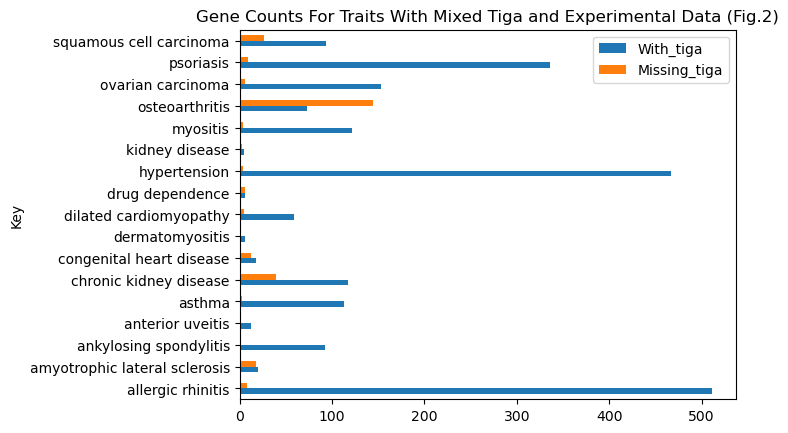

In [149]:
# Finding diseases which have some, but not all, genes with assoicated tiga data
# nans introduced when gene id not in tiga

left_merged = exp.merge(tiga, left_on=["ENSG", "diseaseID"], right_on=["ensemblId", "id"], how="left", validate="1:1")
exp_missing_tiga = left_merged[left_merged.isna().any(axis=1)]
exp_missing_tiga_group = exp_missing_tiga.groupby("diseaseName")
exp_missing_tiga_dict = {k: v for k, v in exp_missing_tiga_group}
exp_missing_tiga_count = {x: len(exp_missing_tiga_dict[x]) for x in exp_missing_tiga_dict.keys()}

exp_with_tiga = exp.merge(tiga, left_on=["ENSG", "diseaseID"], right_on=["ensemblId", "id"], how="inner", validate="1:1")
exp_with_tiga_group = exp_with_tiga.groupby("diseaseName")
exp_with_tiga_dict = {k: v for k, v in exp_with_tiga_group}
exp_with_tiga_count = {x: len(exp_with_tiga_dict[x]) for x in exp_with_tiga_dict.keys()}

tiga_status = pd.DataFrame(columns=["Key", "With_tiga", "Missing_tiga"])
for i in exp_with_tiga_dict.keys():
    if i in exp_missing_tiga_dict.keys():
        row = pd.DataFrame({"Key": [i], "With_tiga": [len(exp_with_tiga_dict[i])], "Missing_tiga": [len(exp_missing_tiga_dict[i])]})
        tiga_status = pd.concat([tiga_status, row], ignore_index=True)

tiga_status.plot(x="Key", kind="barh", stacked=False, title="Gene Counts For Traits With Mixed Tiga and Experimental Data (Fig.2)")

# tiga_status.to_excel("Fig2_data.xlsx")

In [ ]:
g = pd.DataFrame(columns=["key", "with_tiga", "missing_tiga"])

for i in exp["diseaseName"].unique():
    if (i in list(exp_with_tiga["diseaseName"])) and (i in list(exp_missing_tiga["diseaseName"])):
        entry = pd.DataFrame(
            {
                "key": [i],
                "with_tiga": [len(exp_with_tiga[exp_with_tiga["diseaseName"] == i])],
                "missing_tiga": [len(exp_missing_tiga[exp_missing_tiga["diseaseName"] == i])],
            }
        )
        g = pd.concat([g, entry])
    elif i in list(exp_with_tiga["diseaseName"]):
        entry = pd.DataFrame({"key": [i], "with_tiga": [len(exp_with_tiga[exp_with_tiga["diseaseName"] == i])], "missing_tiga": [0]})
        g = pd.concat([g, entry])
    elif i in list(exp_missing_tiga["diseaseName"]):
        entry = pd.DataFrame({"key": [i], "with_tiga": [0], "missing_tiga": [len(exp_missing_tiga[exp_missing_tiga["diseaseName"] == i])]})
        g = pd.concat([g, entry])
    else:
        print(i)

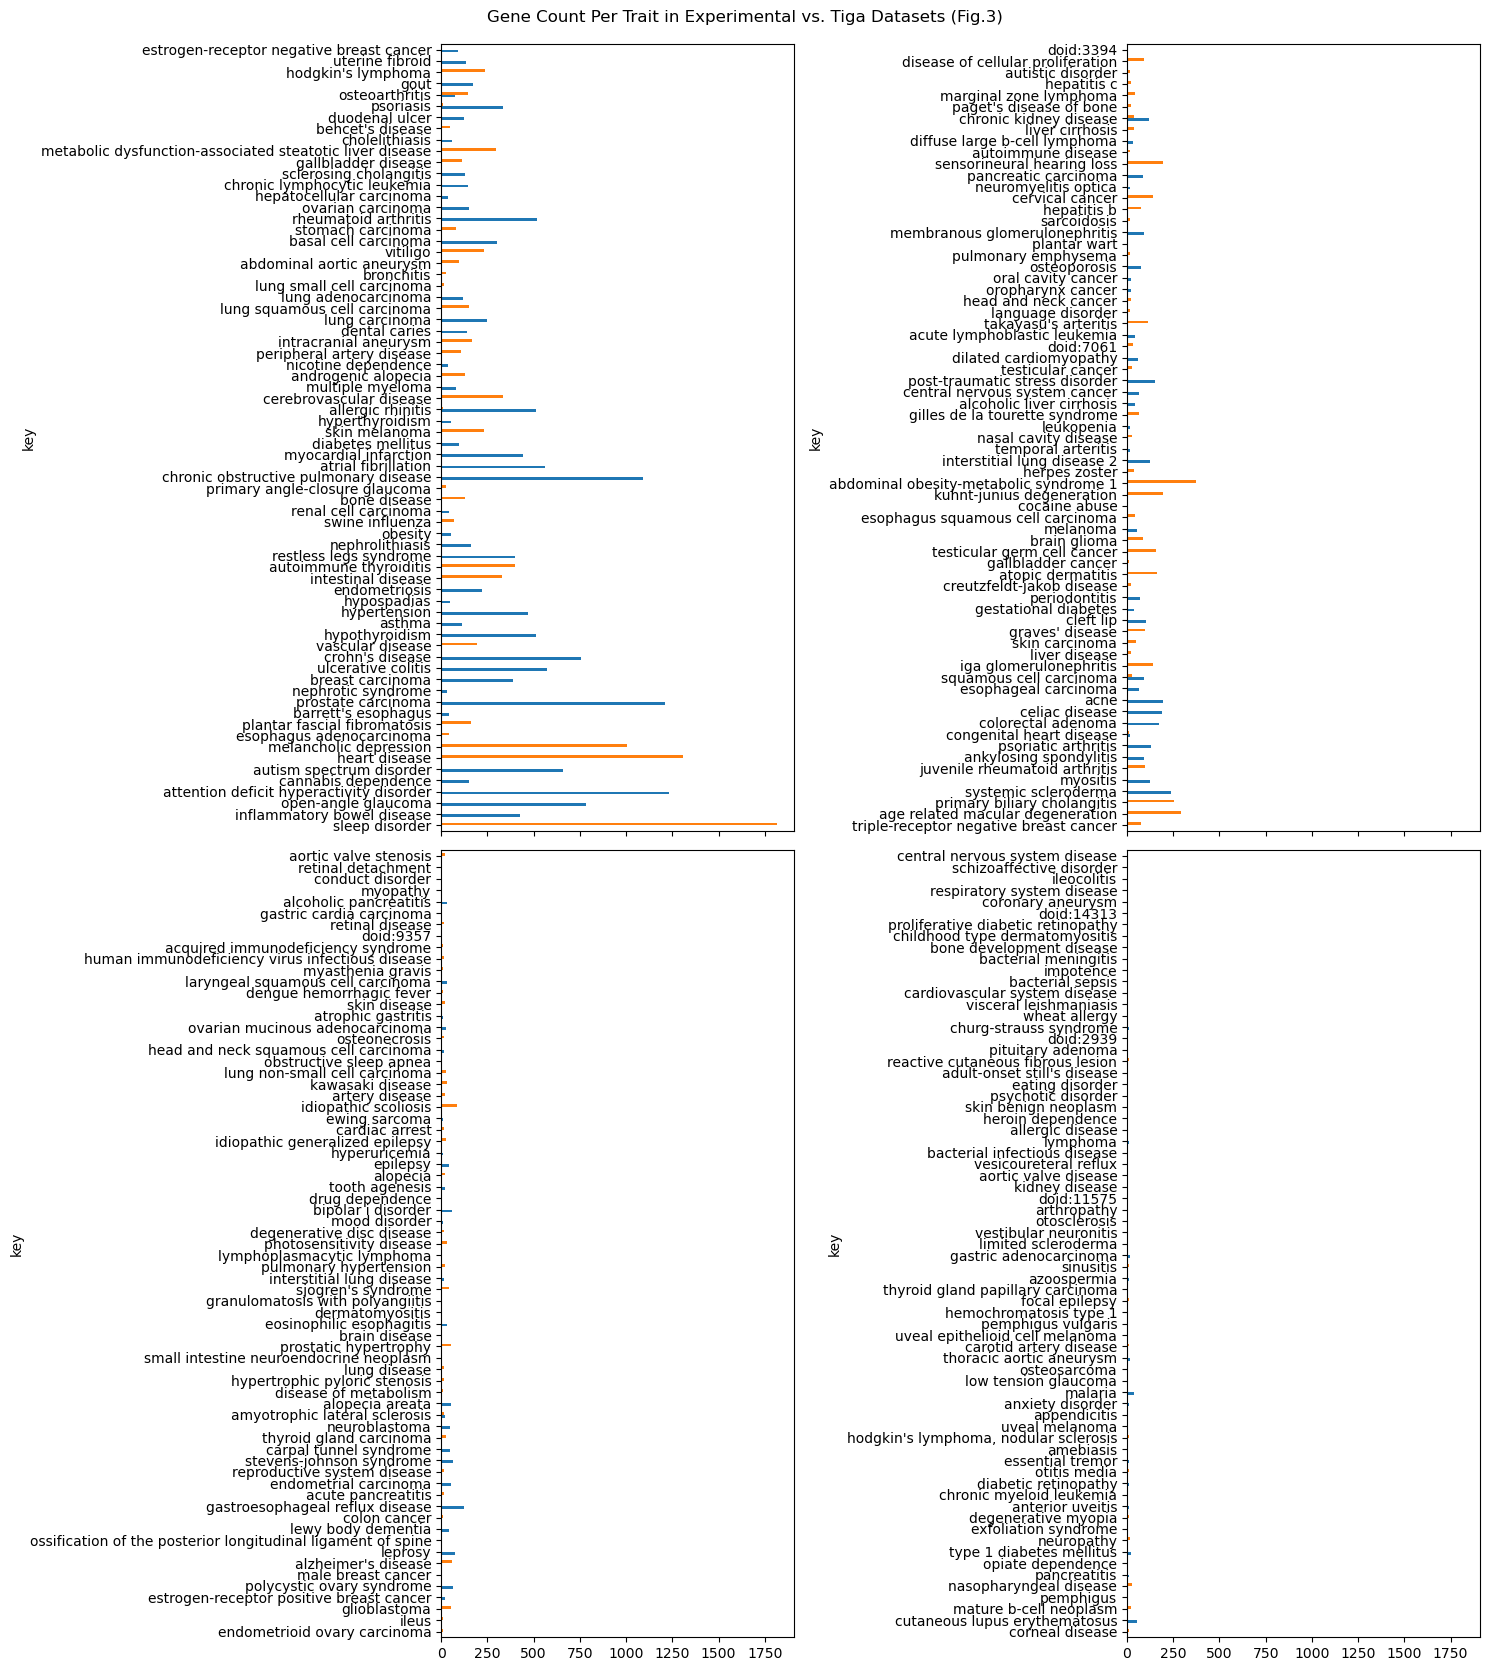

In [150]:
import numpy as np

pd.set_option("display.max_rows", None)

chunks = np.array_split(g, 4)
figs, axs = plt.subplots(2, 2, figsize=(15, 17), sharex=True)
axs = axs.ravel()

plt.subplot(2, 2, 1)
chunks[0].plot(x="key", kind="barh", stacked=False, ax=axs[0], legend=False)

plt.subplot(2, 2, 2)
chunks[1].plot(x="key", kind="barh", stacked=False, ax=axs[1], legend=False)

plt.subplot(2, 2, 3)
chunks[2].plot(x="key", kind="barh", stacked=False, ax=axs[2], legend=False)

plt.subplot(2, 2, 4)
chunks[3].plot(x="key", kind="barh", stacked=False, ax=axs[3], legend=False)

plt.tight_layout(h_pad=1)
plt.suptitle("Gene Count Per Trait in Experimental vs. Tiga Datasets (Fig.3)")
plt.subplots_adjust(top=0.96)

# g.to_excel("Fig3_data.xlsx")

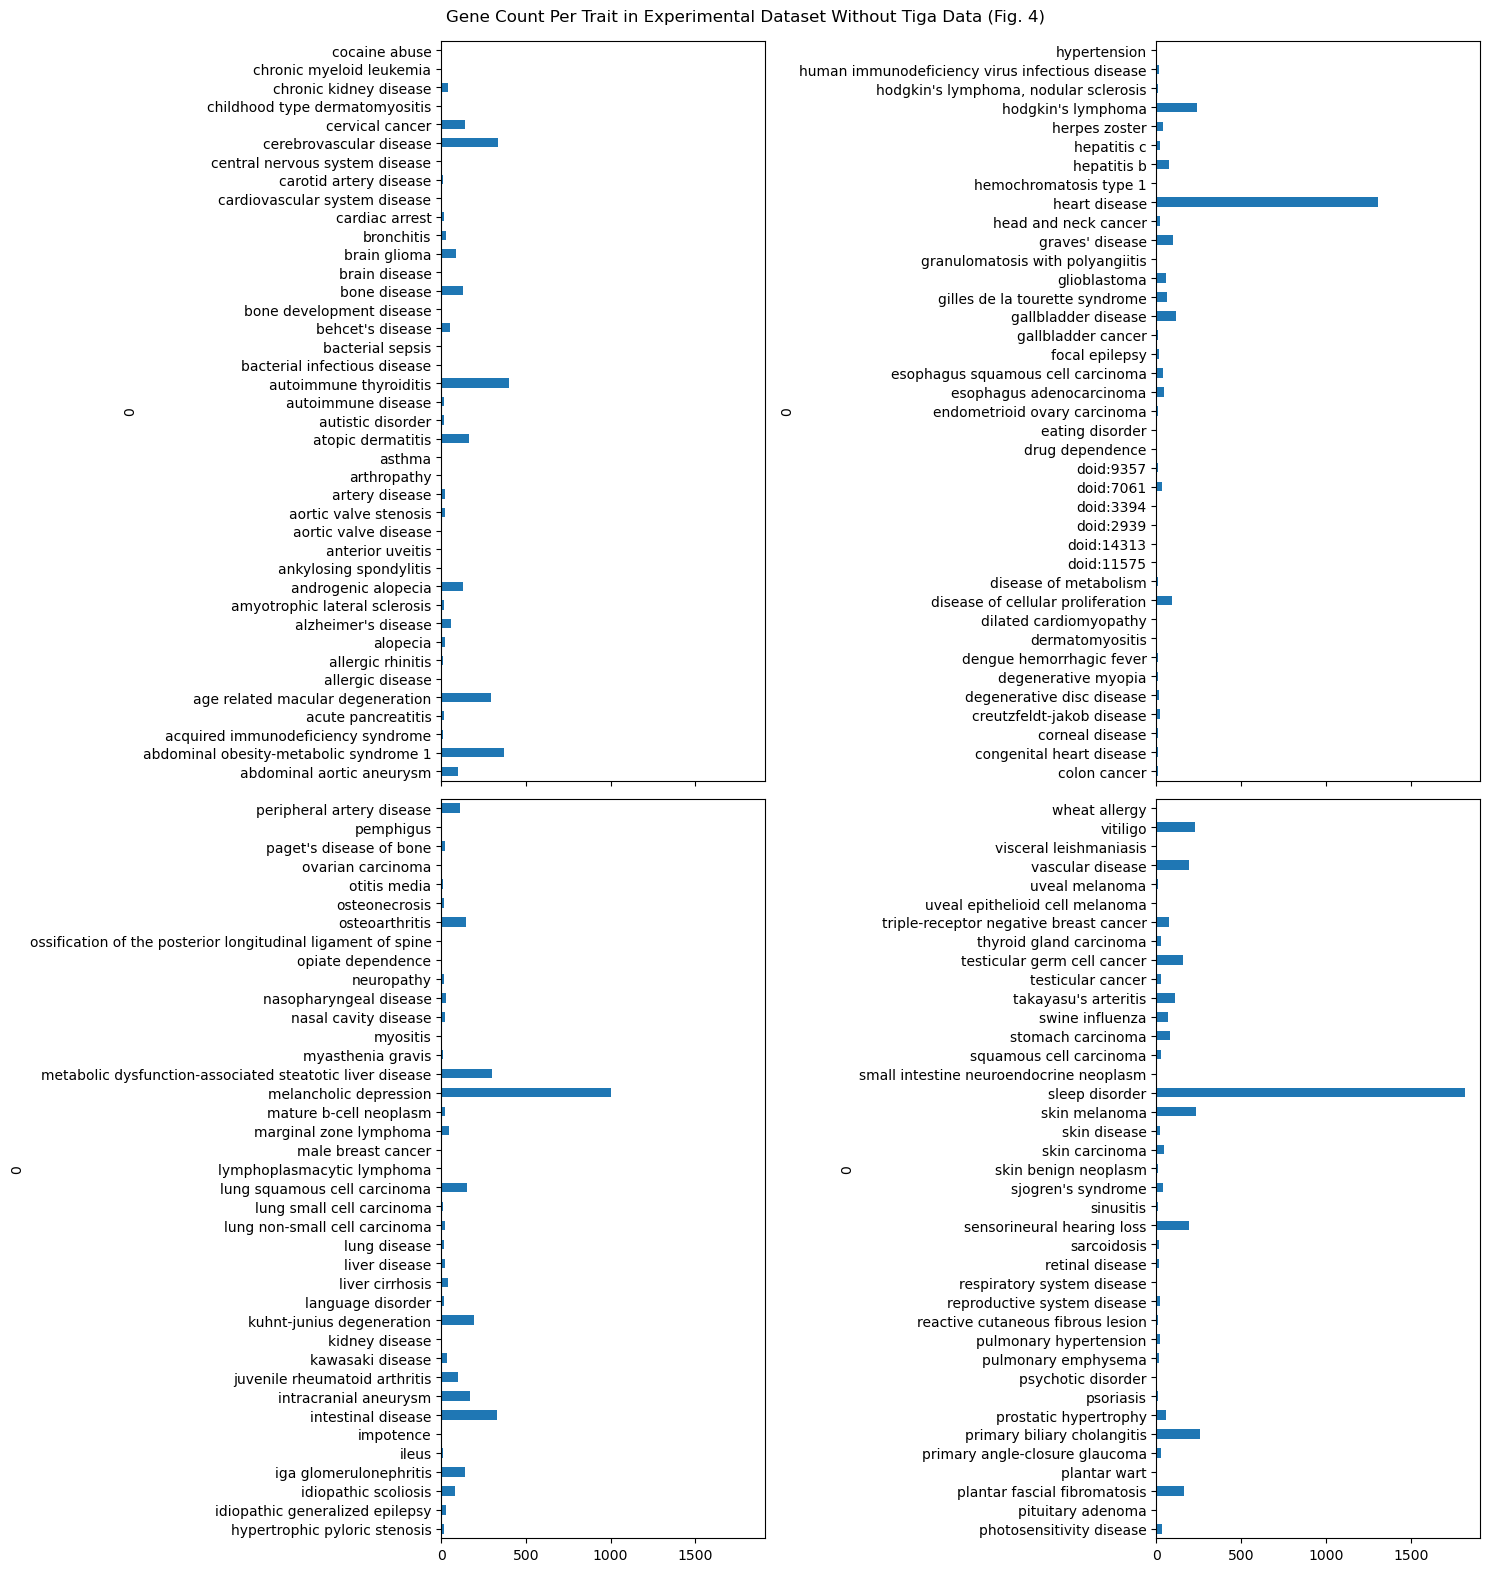

In [ ]:
count_dict = pd.DataFrame.from_dict(exp_missing_tiga_count.items())

chunks = np.array_split(count_dict, 4)
figs, axs = plt.subplots(2, 2, figsize=(15, 16), sharex=True)
axs = axs.ravel()

plt.subplot(2, 2, 1)
chunks[0].plot(x=0, kind="barh", stacked=False, ax=axs[0], legend=False)

plt.subplot(2, 2, 2)
chunks[1].plot(x=0, kind="barh", stacked=False, ax=axs[1], legend=False)

plt.subplot(2, 2, 3)
chunks[2].plot(x=0, kind="barh", stacked=False, ax=axs[2], legend=False)

plt.subplot(2, 2, 4)
chunks[3].plot(x=0, kind="barh", stacked=False, ax=axs[3], legend=False)

plt.tight_layout(h_pad=1)
plt.suptitle("Gene Count Per Trait in Experimental Dataset Without Tiga Data (Fig. 4)")
plt.subplots_adjust(top=0.96)

# count_dict.to_excel("Fig4_data.xlsx")
exp_missing_tiga_count

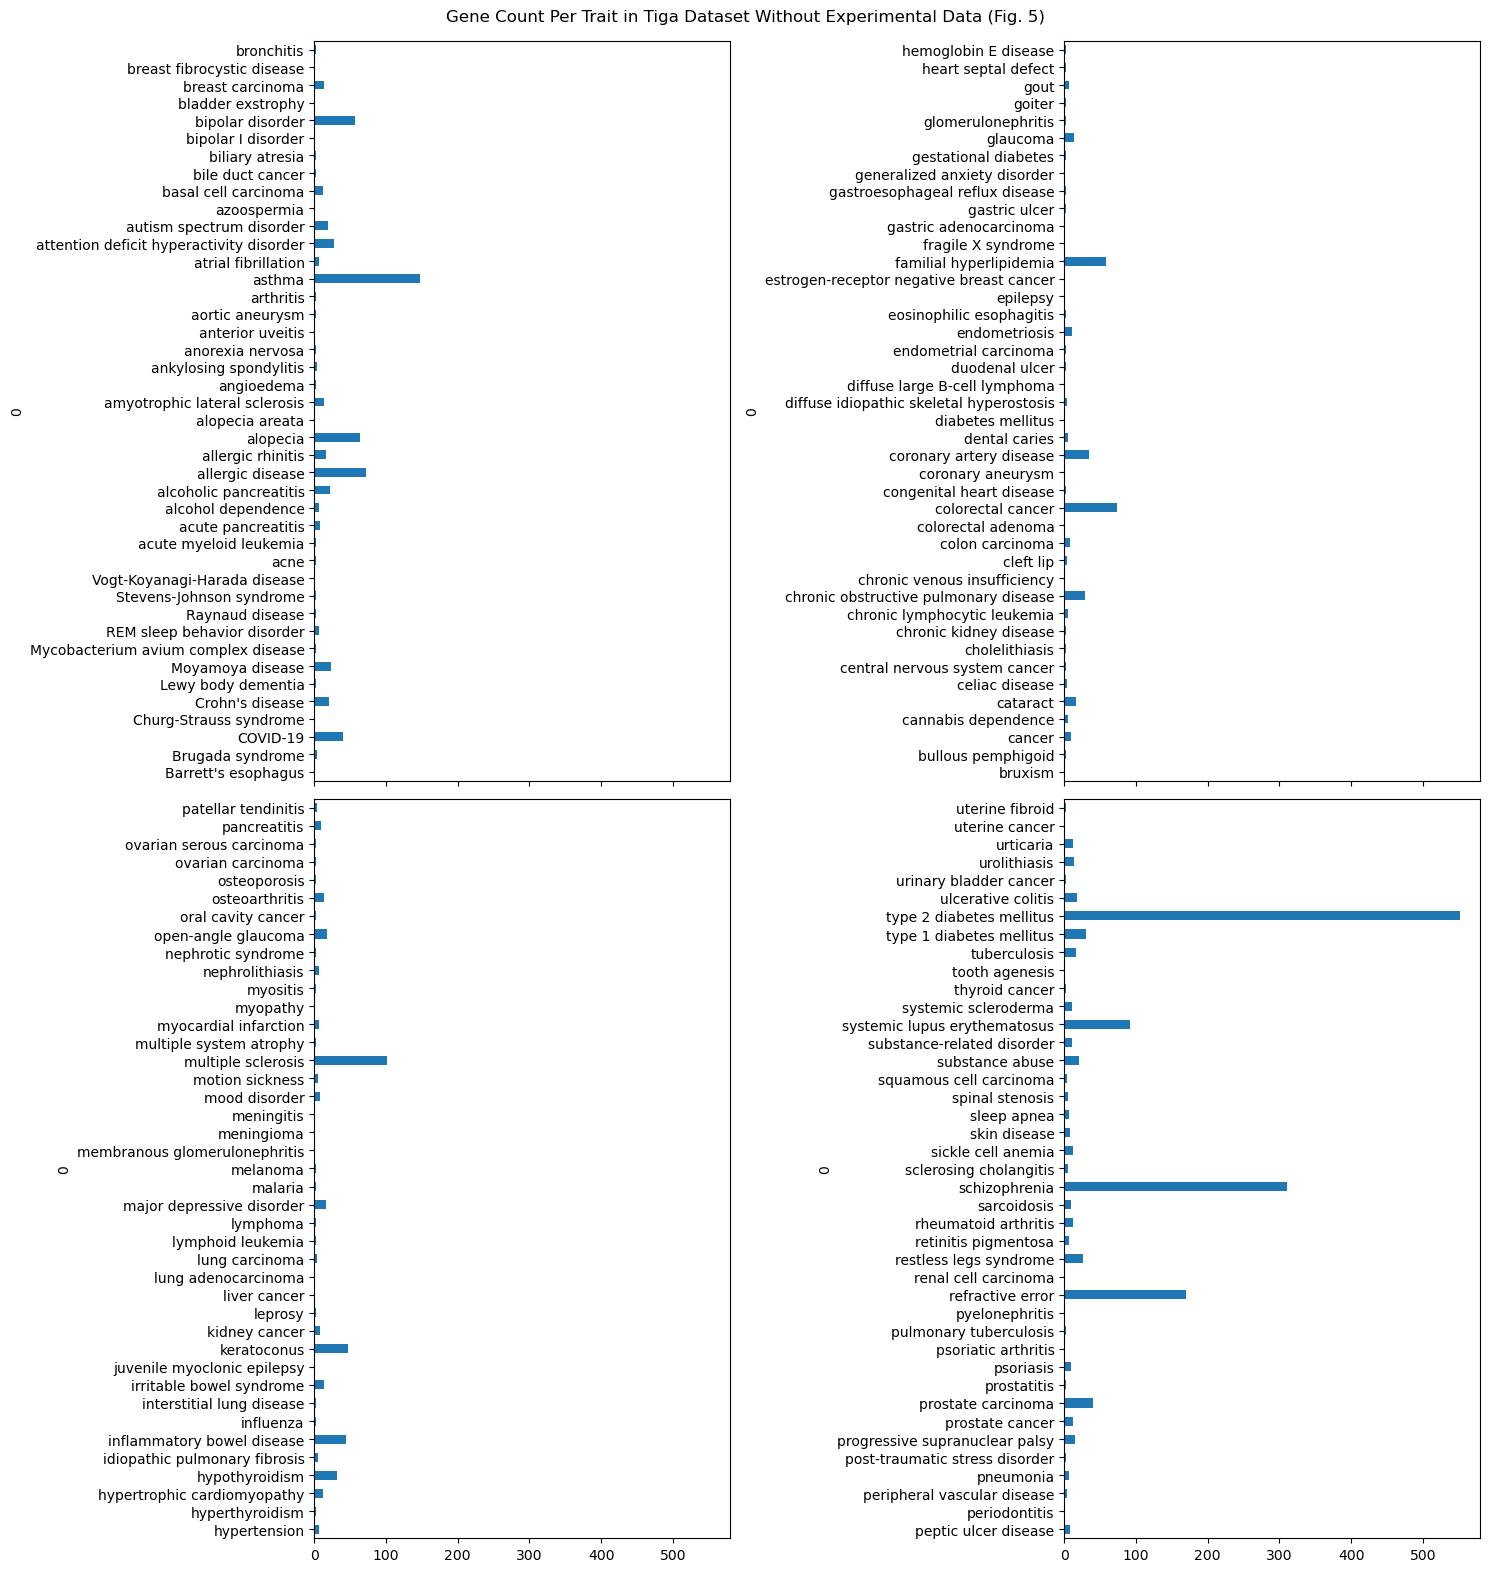

In [ ]:
tme = tiga[~tiga["ensemblId"].isin(list(exp["ENSG"]))]
tme_group = tme.groupby("label")
tme_dict = {k: v for k, v in tme_group}
tme_count = {x: len(tme_dict[x]) for x in tme_dict.keys()}
tme_df = pd.DataFrame.from_dict(tme_count.items())

chunks = np.array_split(tme_df, 4)
figs, axs = plt.subplots(2, 2, figsize=(15, 16), sharex=True)
axs = axs.ravel()

plt.subplot(2, 2, 1)
chunks[0].plot(x=0, kind="barh", stacked=False, ax=axs[0], legend=False)

plt.subplot(2, 2, 2)
chunks[1].plot(x=0, kind="barh", stacked=False, ax=axs[1], legend=False)

plt.subplot(2, 2, 3)
chunks[2].plot(x=0, kind="barh", stacked=False, ax=axs[2], legend=False)

plt.subplot(2, 2, 4)
chunks[3].plot(x=0, kind="barh", stacked=False, ax=axs[3], legend=False)

plt.tight_layout(h_pad=1)
plt.suptitle("Gene Count Per Trait in Tiga Dataset Without Experimental Data (Fig. 5)")
plt.subplots_adjust(top=0.96)

# tme_df.to_excel("Fig5_data.xlsx")

In [283]:
import statistics as stats

# exp_with_tiga
# exp_missing_tiga
# tme

# exp_with_tiga_count
# exp_missing_tiga_count
# tme_count

print(stats.quantiles(exp_with_tiga["confidenceScore"]))
print(stats.quantiles(exp_with_tiga_count.values()))

combined_score_threshold = exp_with_tiga.loc[(exp_with_tiga["confidenceScore"] > 1.1) & (exp_with_tiga["confidenceScore"] < 1.9)]

tst_group = combined_score_threshold.groupby("diseaseName")
tst_dict = {k: v for k, v in tst_group}
tst_count = {x: len(tst_dict[x]) for x in tst_dict.keys()}

combined_count_threshold = {k: v for (k, v) in tst_count.items() if (v > 23 and v < 65)}

combined_score_threshold = combined_score_threshold.loc[combined_score_threshold["diseaseName"].isin(list(combined_count_threshold.keys()))]

print(len(combined_score_threshold))
# combined_score_threshold

[0.887, 1.215, 1.644]
[11.5, 47.0, 127.5]
1455


In [282]:
exp_score_threshold = exp_missing_tiga.loc[(exp_missing_tiga["confidenceScore"] > 1.2) & (exp_missing_tiga["confidenceScore"] < 1.7)]

tst_e_group = exp_score_threshold.groupby("diseaseName")
tst_e_dict = {k: v for k, v in tst_e_group}
tst_e_count = {x: len(tst_e_dict[x]) for x in tst_e_dict.keys()}


exp_count_threshold = {k: v for (k, v) in tst_e_count.items() if (v > 7 and v < 34)}

exp_score_threshold = exp_score_threshold.loc[exp_score_threshold["diseaseName"].isin(list(exp_count_threshold.keys()))]

print(stats.quantiles(exp_missing_tiga["confidenceScore"]))
print(stats.quantiles(tst_e_count.values()))

print(len(exp_score_threshold))

# exp_score_threshold

[0.925, 1.254, 1.677]
[4.0, 8.0, 33.75]
531


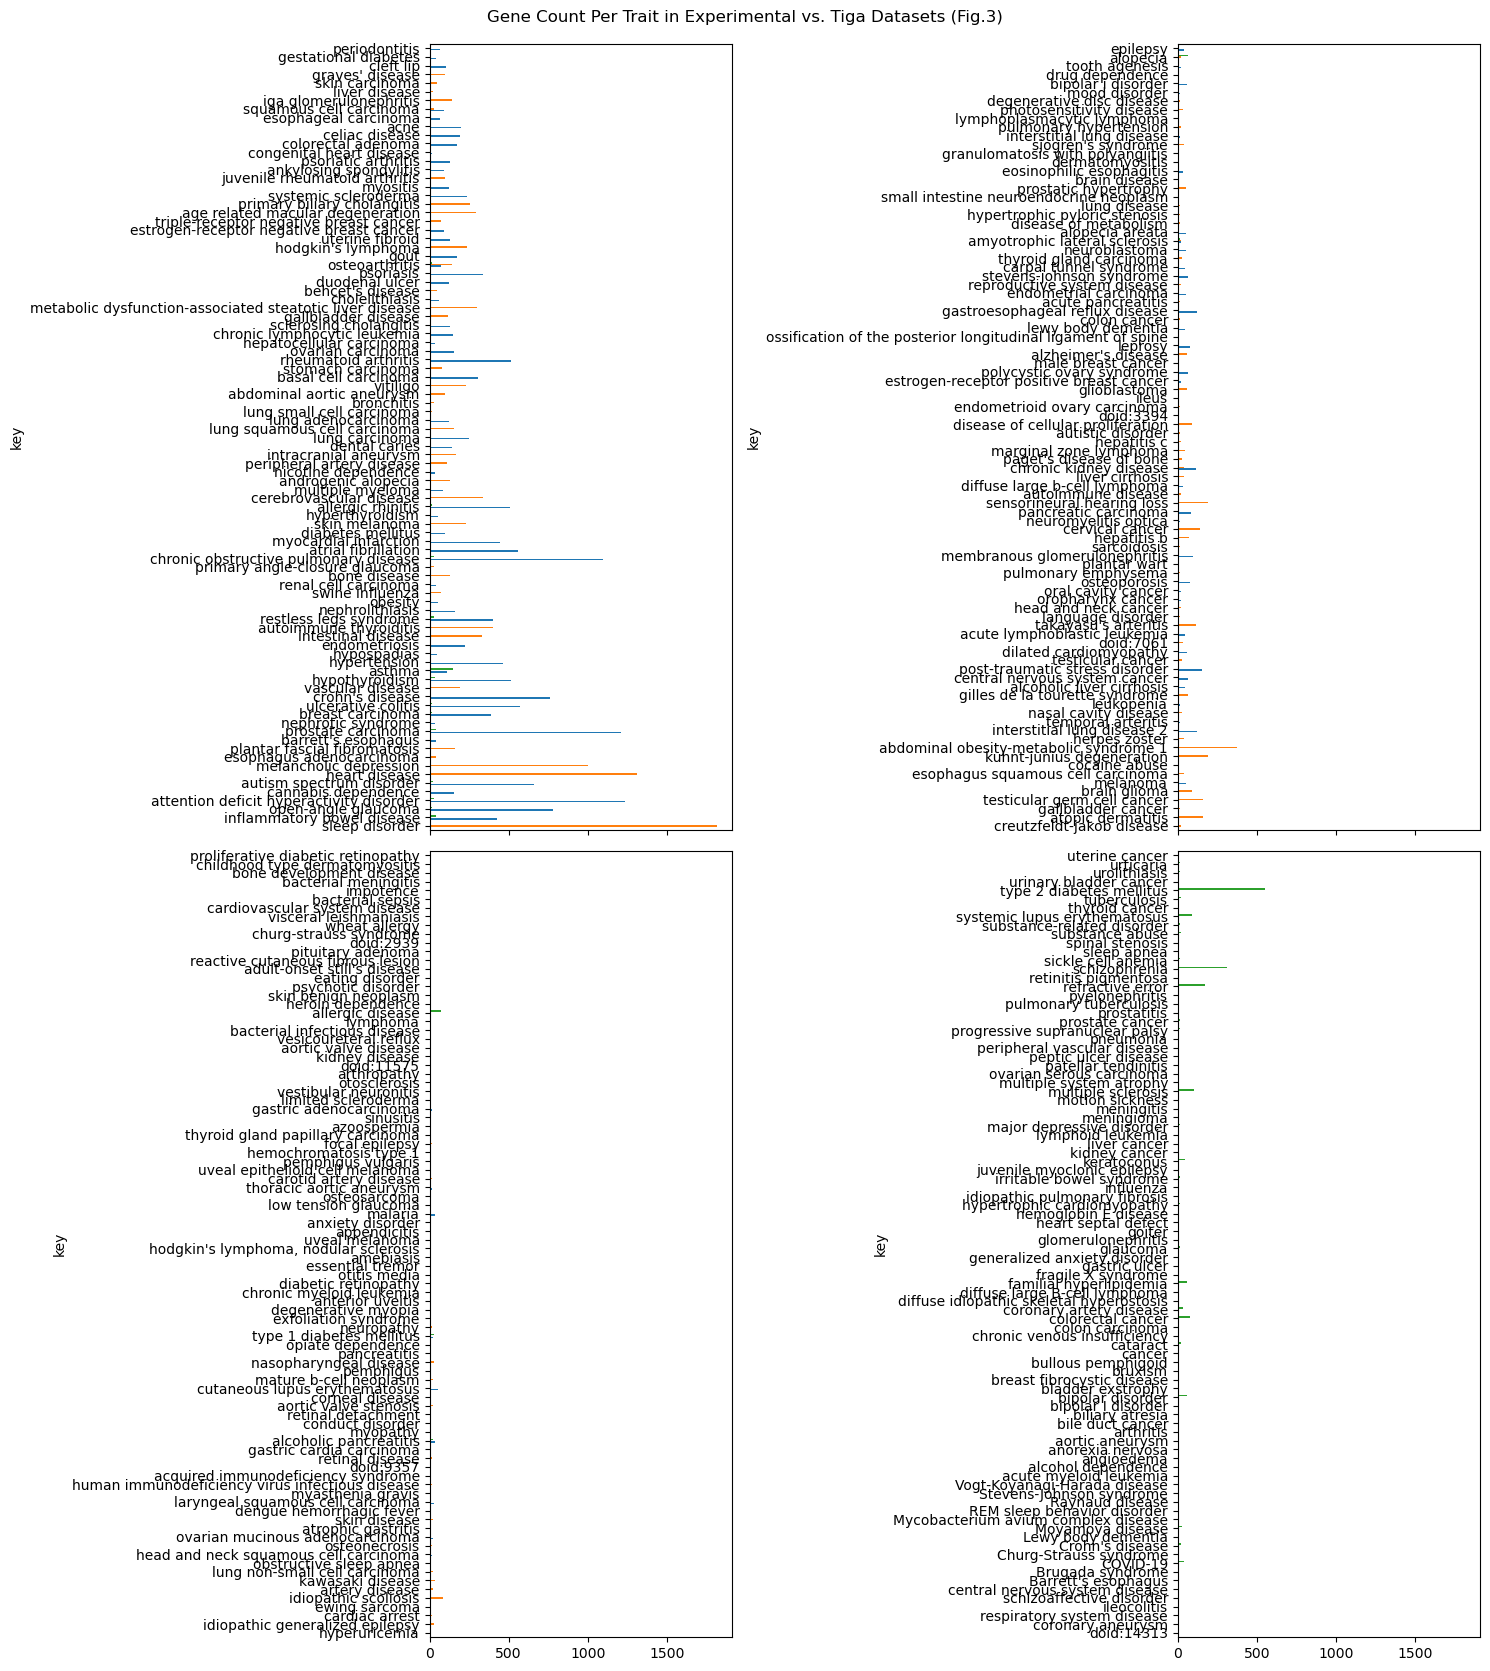

In [ ]:
tst = g
tst["missing_exp"] = 0

for i in tme_count.keys():
    if i in list(tst["key"]):
        tst.loc[tst["key"] == i, "missing_exp"] = tme_count[i]
    elif i not in list(tst["key"]):
        tst = pd.concat([tst, pd.DataFrame({"key": [i], "with_tiga": [0], "missing_tiga": [0], "missing_exp": [tme_count[i]]})])
    else:
        print(i)


chunks = np.array_split(tst, 4)
figs, axs = plt.subplots(2, 2, figsize=(15, 17), sharex=True)
axs = axs.ravel()

plt.subplot(2, 2, 1)
chunks[0].plot(x="key", kind="barh", stacked=False, ax=axs[0], legend=False)

plt.subplot(2, 2, 2)
chunks[1].plot(x="key", kind="barh", stacked=False, ax=axs[1], legend=False)

plt.subplot(2, 2, 3)
chunks[2].plot(x="key", kind="barh", stacked=False, ax=axs[2], legend=False)

plt.subplot(2, 2, 4)
chunks[3].plot(x="key", kind="barh", stacked=False, ax=axs[3], legend=False)

plt.tight_layout(h_pad=1)
plt.suptitle("Gene Count Per Trait in Experimental vs. Tiga Datasets (Fig.3)")
plt.subplots_adjust(top=0.96)

# print(tst.loc[tst['key']=='acne'])

# print(tst)